In [8]:
#!/bin/env python3

from argparse import ArgumentParser
from ast import Str

import numpy as np
from math import comb
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt
import random
import time
import warnings

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D


# wrapper for pylab, designed to do statistical plots using pandas dataframe 
# consider parquet files

from scipy.stats import beta, gaussian_kde


import sys
sys.path.append('/home/kblum/local/pism/sources/pism-emulator/')

from pismemulator.utils import param_keys_dict as keys_dict
from pismemulator.utils import kl_divergence
from pismemulator.kyle_utils import *

import seaborn as sns



In [9]:
#def plot_multiple_groups(dfs,vars,data_group_things):
#    # df : data frame of all models for true avg
#    # vars: list of variable (column) names
#    # models: list of available models (0,1,2 ...)
#    # num_groups: number of ensembles
#    # per_group: number of emulators per ensemble
#
#    sns.set_theme(palette='colorblind')
#    rows = int(np.ceil(len(vars)/2))
#    cols = 2
#
#    fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
#
#    groups = []
#    
#    foo = 0
#    bar = 0
#    for i in range(rows):
#        for j in range (cols):            
#            var = vars[foo]
#            print(var)
#            for count, df in enumerate(dfs):
#                sns.kdeplot(data=df,x=var,ax=axes[int(i),int(j)],label=data_group_things[count]) # remove y axis values, add x axis label
#                axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)
#            axes[int(i),int(j)].legend()
#            foo += 1
#
#def kl_divergences(df,vars,models,num_groups=10,per_group=60):
#    # df : data frame of all models for true avg
#    # vars: list of variable (column) names
#    # models: list of available models (0,1,2 ...)
#    # num_groups: number of ensembles
#    # per_group: number of emulators per ensemble
#
#    divs = {}
#    groups = []
#
#    random.seed(8675309)
#    for i in range(num_groups):
#        groups.append(random.sample(sorted(models),per_group))
#    
#    bar = 0
#    for i in range(len(vars)):
#        kl_average = 0
#        var = vars[i]
#        p = np.histogram(df[var], bins=30,density=True)[0]
#        for group in groups:
#            temp = df[df['Model'].isin(group)]
#            q = np.histogram(temp[var],bins=30,density=True)[0]
#            kl_average += np.abs(kl_divergence(p,q))
#        kl_average  = kl_average / num_groups
#        divs[var] = kl_average
#    return divs

In [10]:
emulator_dirs = []
clever_var_name = [250,500,750,1000]
for i in clever_var_name:
    emulator_dir = f"/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_50m_{i}t_1000e"
    emulator_dirs.append(emulator_dir)

emulator_dir = f"/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_200m_1275t_1000e"
emulator_dirs.append(emulator_dir)
# emulator_dirs.append(2021_11_pseudo_plastic_kb)
samples_file = "/data/work/antarctica_calibration/speed_calibration_pseudo_plastic_128.csv"
frac         = 0.1

print("Loading prior samples\n")
samples = pd.read_csv(samples_file).drop(columns=["id"])

X = samples.values
X_keys = samples.keys()
#n_samples, n_parameters = X.shape

#l_post = []


Loading prior samples



In [11]:
samples

,sia_e,ssa_e,ppq,tefo,phi_min,z_min,z_max,pseudo_plastic_uthreshold
0,1.035156,0.998047,0.455078,0.023613,28.046875,-324.21875,863.28125,49.21875
1,1.316406,0.998047,0.455078,0.023613,28.046875,-324.21875,863.28125,49.21875
2,1.035156,1.724609,0.455078,0.023613,28.046875,-324.21875,863.28125,49.21875
3,1.035156,0.998047,0.766797,0.023613,28.046875,-324.21875,863.28125,49.21875
4,1.035156,0.998047,0.455078,0.048223,28.046875,-324.21875,863.28125,49.21875
...,...,...,...,...,...,...,...,...
1275,1.011719,1.994141,0.788672,0.040840,13.984375,-19.53125,886.71875,35.15625
1276,1.011719,1.994141,0.788672,0.040840,22.265625,-363.28125,886.71875,35.15625
1277,1.011719,1.994141,0.788672,0.040840,22.265625,-19.53125,613.28125,35.15625
1278,1.011719,1.994141,0.788672,0.040840,22.265625,-19.53125,886.71875,103.90625


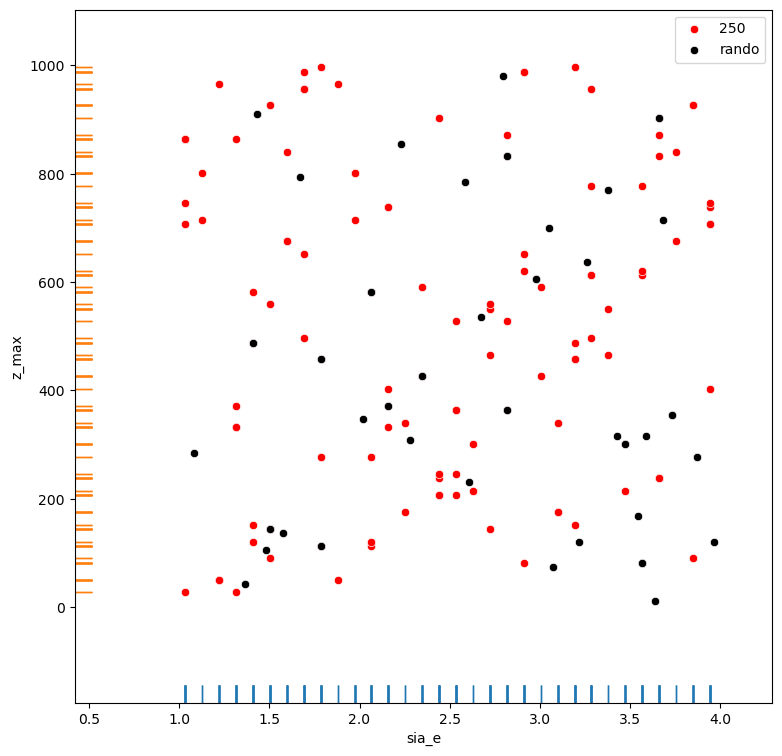

In [12]:
var1='sia_e'
var2='z_max'  
start  =   0
stop   = 250
number = stop-start

fig = plt.figure(figsize=(9,9))
#whole   = sns.scatterplot(x=samples[var1],y=samples[var2],legend=True,label='1280',color='green')
partial = sns.scatterplot(x=samples[var1][start:stop],y=samples[var2][start:stop],legend=True,label=f'{number}',color='red')
rug1    = sns.rugplot(x=samples[var1][start:stop])
rug2    = sns.rugplot(y=samples[var2][start:stop])
rando   = sns.scatterplot(x=samples[var1].sample(n=number),y=samples[var2].sample(n=number),color='black',legend=True,label='rando')


In [13]:
posterior_dfs = []
#models_list = []
for emulator_dir in emulator_dirs:
        
    X_list = []
    
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        #print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=1)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    # Very janky, going to need to stop getting variables from file names at some point
    training = emulator_dir.split("_")[4].split("t")[0]
    print(training)
    print(f"Merging posteriors into dataframe")

    posterior_df = pd.concat(X_list)
    posterior_df["Training"] = int(training)
    
    print(training)
    posterior_dfs.append(posterior_df)
    #X_posterior = posterior_df.drop(columns=["Model"]).values
    models = posterior_df['Model'].unique()
    #models_list.append(models)


Loading posterior samples

250
Merging posteriors into dataframe
250
Loading posterior samples

500
Merging posteriors into dataframe
500
Loading posterior samples

750
Merging posteriors into dataframe
750
Loading posterior samples

1000
Merging posteriors into dataframe
1000
Loading posterior samples

1275
Merging posteriors into dataframe
1275


In [14]:
posterior_dfs


[          sia_e     ssa_e       ppq      tefo    phi_min      z_min  \
 847    1.089921  0.692241  0.521707  0.047011  21.216105 -577.45540   
 2227   1.095227  0.694867  0.500484  0.043991  20.881723 -582.76630   
 2764   1.091519  0.669441  0.506619  0.046366  21.607445 -617.89886   
 327    1.082847  0.709193  0.525081  0.045652  20.727010 -534.55600   
 2383   1.088890  0.692952  0.494541  0.045439  21.409810 -527.38600   
 ...         ...       ...       ...       ...        ...        ...   
 17825  1.084213  0.787889  0.619411  0.039762  19.326340 -536.75150   
 24208  1.097575  0.778298  0.619078  0.040047  19.578650 -527.57990   
 86346  1.081350  0.774842  0.641744  0.040884  19.647057 -513.15050   
 12270  1.089451  0.770324  0.612450  0.039896  19.592413 -556.40155   
 69250  1.094353  0.761794  0.598662  0.040533  19.307873 -538.79940   
 
            z_max  pseudo_plastic_uthreshold  Model  Training  
 847    322.91553                  97.321160      0       250  
 2227 

ValueError: Could not interpret value `Training` for parameter `hue`

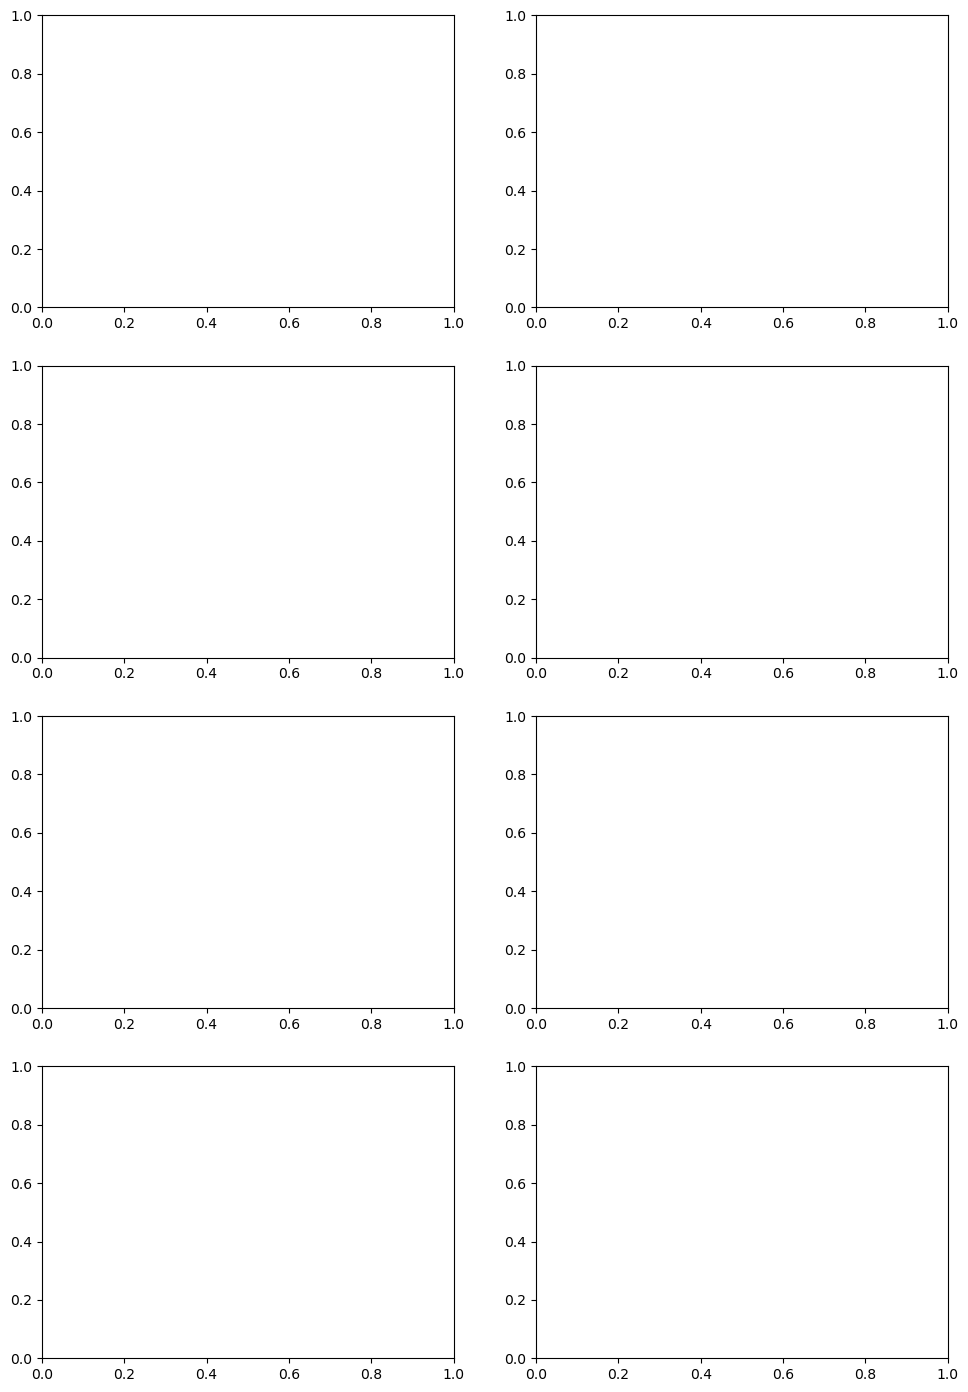

In [18]:
rows = 4
cols = 2
foo = 0
fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
for i in range(rows):
    for j in range (cols):            
        var = X_keys[foo]
        sns.kdeplot(data=df, x=var,ax=axes[int(i),int(j)], hue='Training')
        foo += 1
        axes[int(i),int(j)].legend()

<class 'list'>
1
2
3
4
5


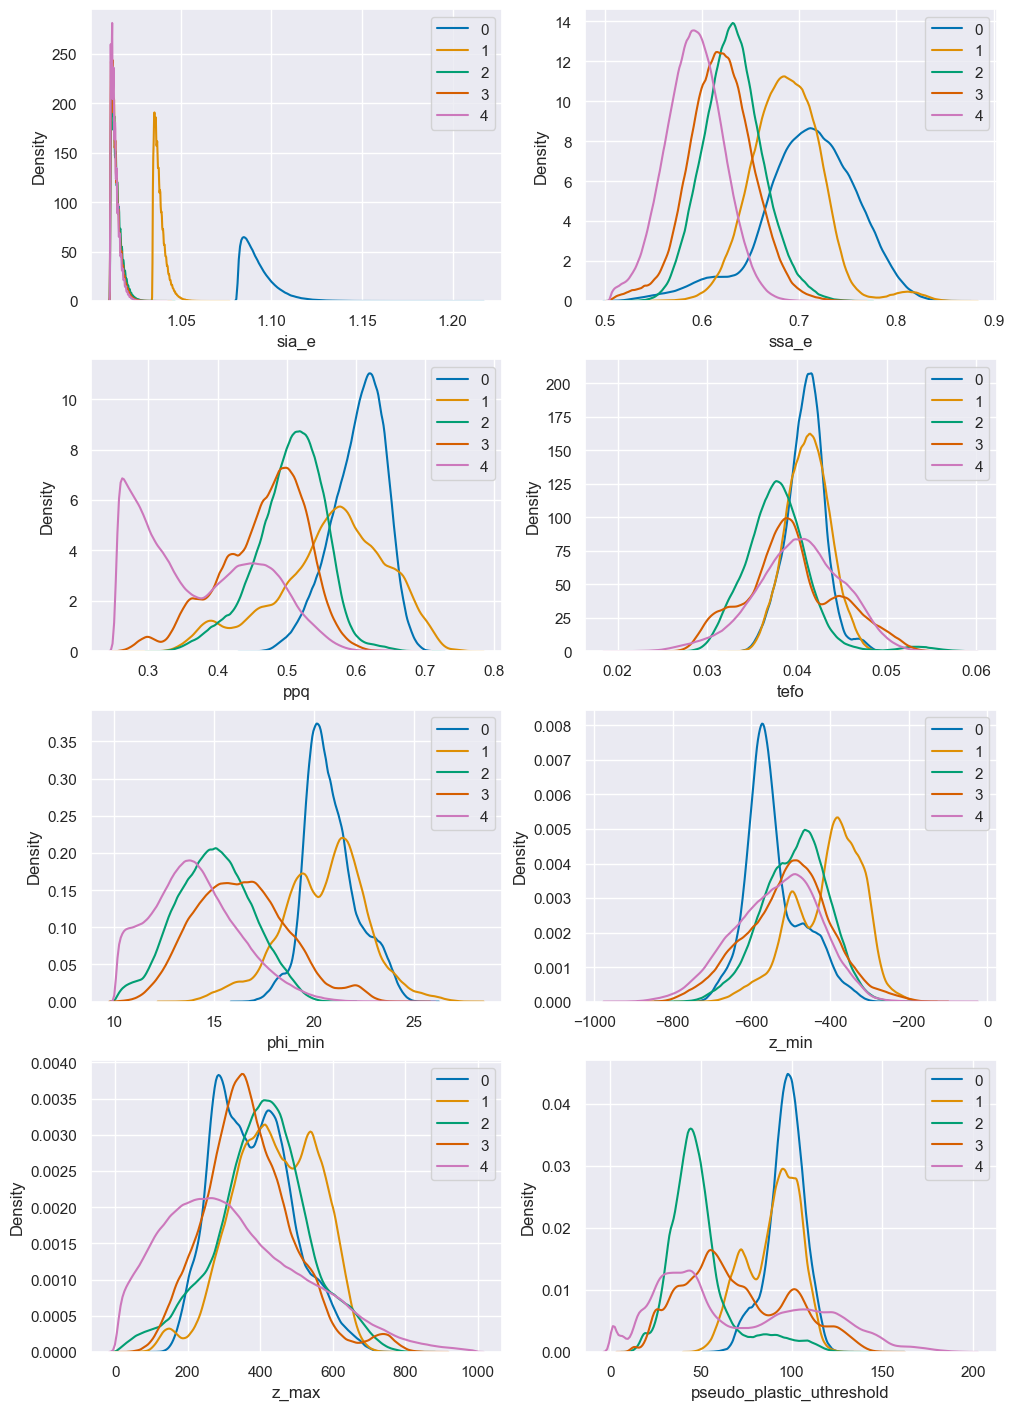

In [6]:
plot_posteriors(dfs=posterior_dfs,vars=X_keys)

In [7]:
#print(len(posterior_dfs[0]))
for i in range(5):
    print(len(posterior_dfs[i]))

4755050
4950050
4950050
4933050
19641200


In [7]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
count = 0
for foo in posterior_dfs:
    lcurves[clever_var_name[count]] = (kl_deviation(foo,X_keys))
    count+=1

In [8]:
var = 'ssa_e'
df = posterior_dfs[2]
temp = df[df['Model']==0]
q = np.histogram(temp[var],bins=1000,density=True)[0]

In [9]:
kl_deviation(df=df, vars=X_keys)

{'sia_e': 176.79132347661908,
 'ssa_e': 61.6738850476667,
 'ppq': 43.90950604984171,
 'tefo': 403.83629440842265,
 'phi_min': 0.8538306645224176,
 'z_min': 0.028496632119094572,
 'z_max': 0.016944183178172093,
 'pseudo_plastic_uthreshold': 0.109807455770084}

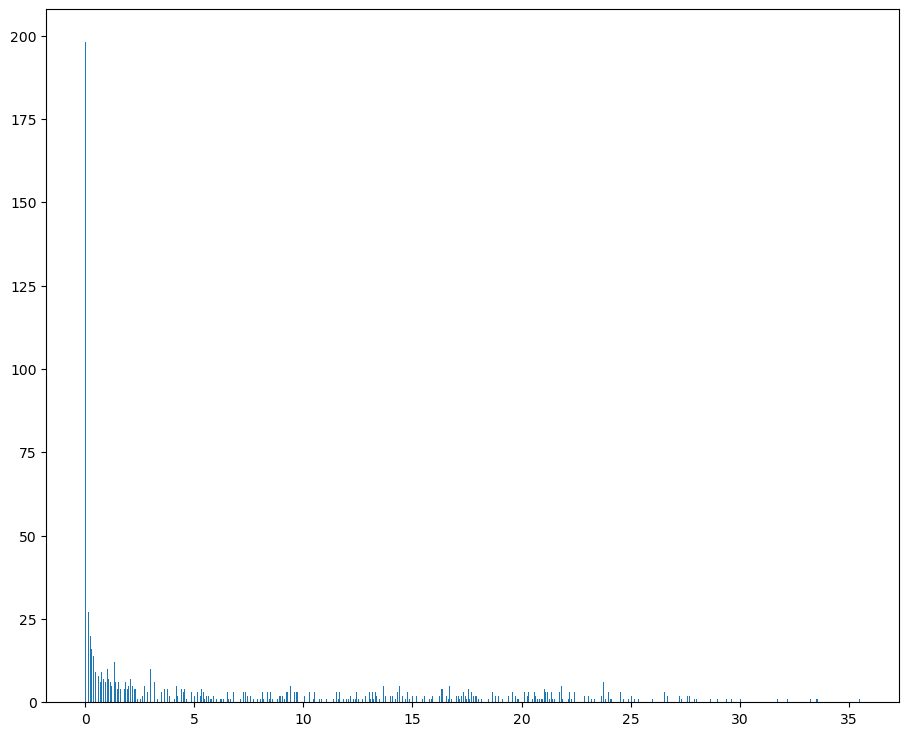

In [10]:
fig  = plt.figure(figsize=(11,9))
plot = plt.hist(q,1000)

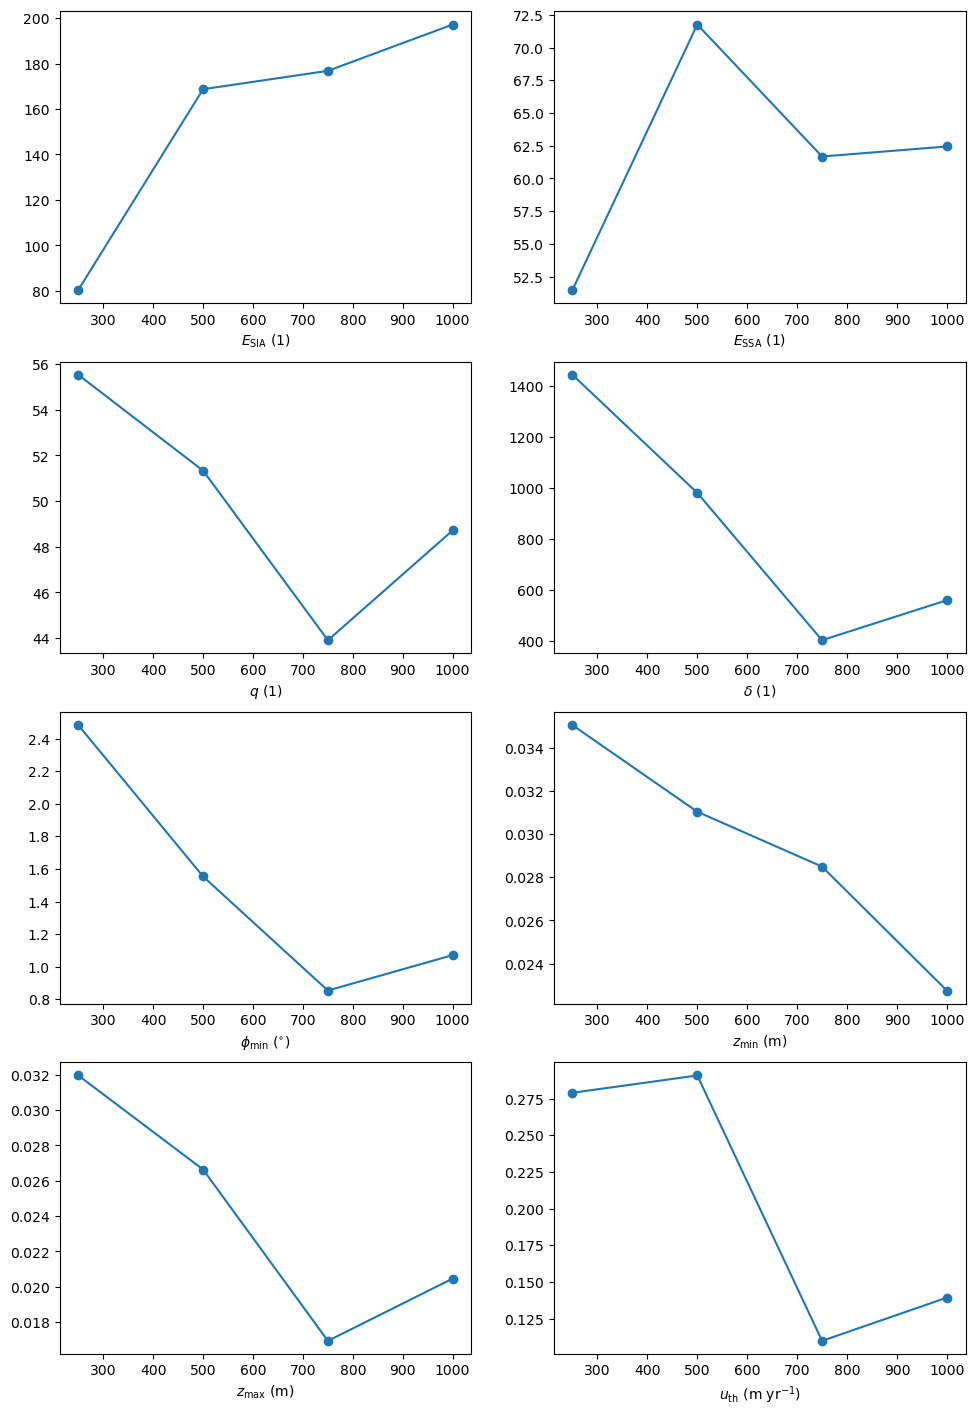

In [53]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

# change graph labels to be accurate

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        xs = [250,500,750,1000]
        ys = []
        
        for bar in clever_var_name:
            ys.append(lcurves[bar][var])
        foo += 1
        
        axes[i,j].plot(xs,ys,'o-')
        axes[i,j].set(xlabel=keys_dict[var])

In [12]:
#plot_posteriors(posterior_dfs, X_keys,labels=clever_var_name) 

In [58]:
thin_by = .0001
cor_dfs = []
count = 0
if thin_by > 0 and thin_by < 1:
    for training_points in clever_var_name:
        cor_df = posterior_dfs[count].drop('Model',axis=1).sample(frac=thin_by)
        count += 1
        cor_dfs.append(cor_df)
else:
    for training_points in clever_var_name:
        cor_df = posterior_dfs[count].drop('Model',axis=1)
        cor_dfs.append(cor_df)
        count += 1

cor_df = pd.concat(cor_dfs)


In [62]:
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    if label == 250:
        pos = (.25,.75)
    elif label == 500:
        pos = (.75,.75)
    elif label == 750:
        pos = (.25,.25)
    elif label == 1000:
        pos = (.75,.25)
    else:
        pos = (.5,.5)
    ax.annotate('r = {:.2f}'.format(r), xy=pos, xycoords='axes fraction', ha='center',color=color,fontsize=15)
    ax.set_axis_off()

In [ ]:
g = sns.PairGrid(cor_df,diag_sharey=False,hue='Training',palette='dark',hue_order=[1000,750,500,250])
g.map_diag(sns.kdeplot)
g.map_lower(sns.scatterplot,alpha=.1)
g.map_lower(sns.kdeplot, levels=1)
g.add_legend()
g.map_upper(reg_coef)

In [ ]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
xs = np.linspace(5,200,40)
for per_group in xs:
    print(per_group)
    lcurves[per_group] = kl_divergences(posterior_df, X_keys, models, per_group=int(per_group),num_groups=20)

In [ ]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        foo += 1
        ys = []
        for bar in xs:
            ys.append(lcurves[bar][var])
        
        axes[i,j].plot(xs,ys,'k.-')
        axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)


In [ ]:
#print(plot_groups(posterior_df, X_keys, models, per_group=15))
for pergroup in [15,50,100]:
    print(kl_divergences(posterior_df, X_keys, models, per_group=int(pergroup),num_groups=20)['ppq'])